100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/10: Train Loss: 1.3473, Test Loss: 1.0675, Accuracy: 0.6185
Epoch 2/10: Train Loss: 0.9602, Test Loss: 0.9536, Accuracy: 0.6667
Epoch 3/10: Train Loss: 0.7982, Test Loss: 0.8456, Accuracy: 0.7063
Epoch 4/10: Train Loss: 0.6738, Test Loss: 0.8470, Accuracy: 0.7128
Epoch 5/10: Train Loss: 0.5706, Test Loss: 0.8400, Accuracy: 0.7219
Epoch 6/10: Train Loss: 0.4731, Test Loss: 0.8548, Accuracy: 0.7234
Epoch 7/10: Train Loss: 0.3868, Test Loss: 0.9077, Accuracy: 0.7240
Epoch 8/10: Train Loss: 0.3078, Test Loss: 1.0242, Accuracy: 0.7089
Epoch 9/10: Train Loss: 0.2424, Test Loss: 1.0415, Accuracy: 0.7226
Epoch 10/10: Train Loss: 0.1880, Test Loss: 1.1634, Accuracy: 0.7099


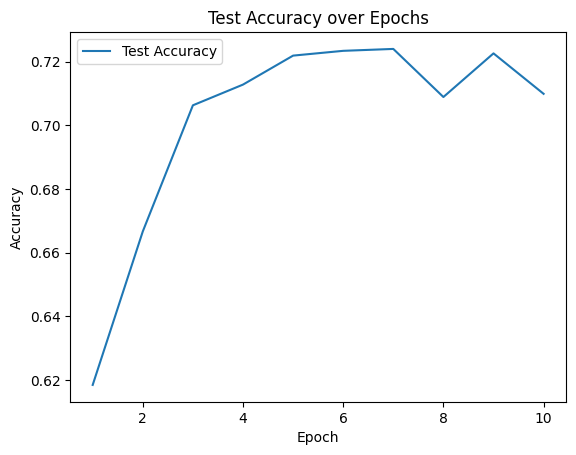

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define data transformations and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First conv: input channels=3, output channels=32, kernel=3, padding=1 (to keep same size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Second conv: input channels=32, output channels=64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Max pooling layer with a window of 2x2.
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers: first from flattened conv output to 128, then to 10 classes.
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply first conv layer, activation, and pooling.
        x = self.pool(F.relu(self.conv1(x)))  # Output shape: [batch_size, 32, 16, 16]
        # Apply second conv layer, activation, and pooling.
        x = self.pool(F.relu(self.conv2(x)))  # Output shape: [batch_size, 64, 8, 8]
        # Flatten the output for the fully connected layers.
        x = x.view(-1, 64 * 8 * 8)
        # Apply first fully connected layer and activation.
        x = F.relu(self.fc1(x))
        # Final output layer (logits for each class).
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
epochs = 10
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Loop over batches in the training set
    for images, labels in train_loader:
        optimizer.zero_grad()              # Zero the gradients from the previous step
        outputs = model(images)            # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()                    # Backward pass: compute gradient of the loss
        optimizer.step()                   # Update model parameters

        # Accumulate loss for this epoch
        running_loss += loss.item() * images.size(0)

    # Calculate average loss for this epoch.
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    test_loss = 0.0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            # Get the class with the highest logit
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    # Calculate average test loss and accuracy.
    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    accuracy = correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot accuracy over epochs
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

In [2]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
